In [1]:
import sys,copy,re,importlib,pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import math, scipy, sys
from IPython.display import display
from functools import reduce
import pathlib
import sklearn
import matplotlib.pyplot as plt
#import plotly
#import plotly.express as px
import sklearn.ensemble, sklearn.metrics, sklearn.feature_selection, sklearn.preprocessing, sklearn.decomposition
import sklearn.model_selection, sklearn.utils, sklearn.linear_model, sklearn.pipeline, sklearn.manifold
import sklearn.naive_bayes,sklearn.discriminant_analysis,sklearn.base
import condor_tensorflow as condor
import dython,pickle
from apps.attritionml import mlmodeldefinition
importlib.reload(mlmodeldefinition)
pd.set_option('display.max_columns', 5000)

In [2]:
testInputDfFile = (pathlib.Path() / 'attritionproject.csv').resolve()
srcdf = pd.read_csv(testInputDfFile)

## 檢查遺漏值，區別變數型態

In [3]:
continueousVars = []
categoricalVars = []
for col in srcdf.columns:
  missingvaluesNA = pd.isna(srcdf[col])
  missingvaluesNull = pd.isnull(srcdf[col])
  if sum(missingvaluesNA)>0 or sum(missingvaluesNull)>0:
    print(f'number of missing value at column {col} > 0')
  if col=='Attrition':
    pass
  elif srcdf[col].dtype=='object':
    categoricalVars.append(col)
    print('column {} has {} levels'.format(col, len(srcdf[col].unique()) ))
  else:
    continueousVars.append(col)
display('continueousVars are {}'.format(continueousVars))

column BusinessTravel has 3 levels
column Department has 3 levels
column EducationField has 6 levels
column Gender has 2 levels
column JobRole has 9 levels
column MaritalStatus has 3 levels
column Over18 has 1 levels
column OverTime has 2 levels


"continueousVars are ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']"

In [4]:
display(srcdf, srcdf[continueousVars].describe(), srcdf[categoricalVars].describe())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470
unique,3,3,6,2,9,3,1,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1043,961,606,882,326,673,1470,1054


#### 檢查資料有沒有分布過偏、需要整併的情形 順便觀察到應變數分布情形（發現資料不平衡）

In [5]:
srcdf = pd.read_csv(testInputDfFile)
srcdfY = srcdf.loc[:,'Attrition']
lbzedSrcdfY = sklearn.preprocessing.LabelBinarizer().fit(srcdfY)
pd.DataFrame(data={'srcdfY':srcdfY, 'lbzedSrcdfY':lbzedSrcdfY.transform(srcdfY)[:,0]})

,srcdfY,lbzedSrcdfY
0,Yes,1
1,No,0
2,Yes,1
3,No,0
4,No,0
...,...,...
1465,No,0
1466,No,0
1467,No,0
1468,No,0


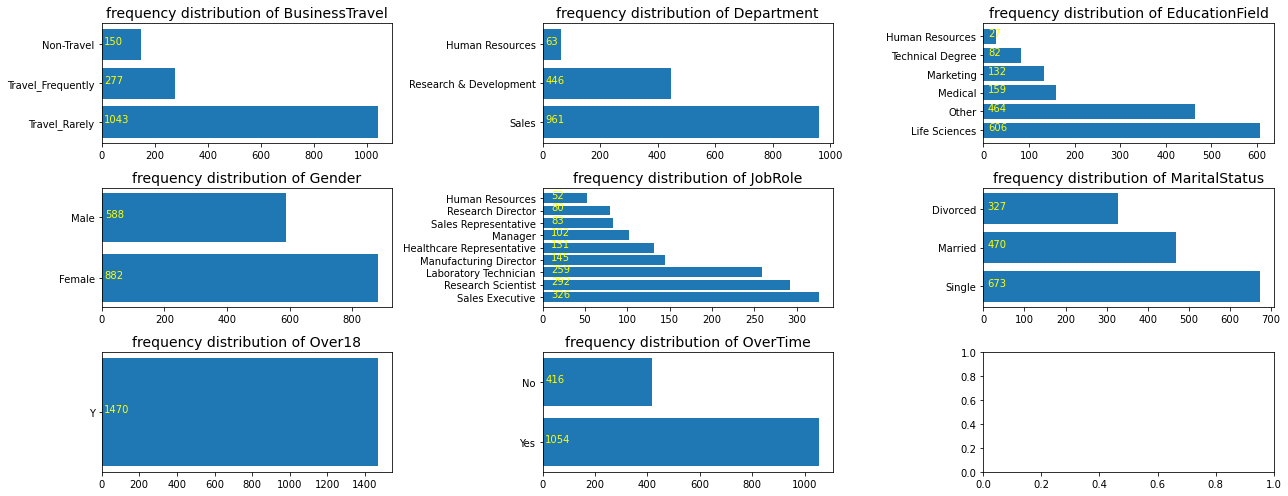

In [6]:
def plotVarsDist(srcd=srcdf, subplots=True, nSubplotCols=3, vartype='conti', displayVars=None, chartType='hist', figsize=(18, 10), titlefontsize=14):
    categoricalVars = [col for col in srcd if srcd[col].dtype in ['object','category']] if displayVars is None else displayVars
    continueousVars = [col for col in srcd if srcd[col].dtype not in ['object','category']] if displayVars is None else displayVars
    if displayVars==None:
        listvars = categoricalVars if vartype=='catg' else continueousVars
    else:
        listvars = displayVars
    if subplots:
        fig, ax = plt.subplots(math.ceil(len(listvars)/nSubplotCols), nSubplotCols, figsize=figsize)
        rowi = -1
        for i,col in enumerate(listvars):
            if i%nSubplotCols==0:
                rowi += 1
            if vartype=='catg':
                ax[rowi][i%nSubplotCols].barh(srcd[col].unique(),srcd[col].value_counts())
                ax[rowi][i%nSubplotCols].set_title(f"frequency distribution of {col}", fontsize=titlefontsize)
                for labeltexti, labeltext in enumerate(srcd[col].value_counts()):
                    ax[rowi][i%nSubplotCols].text(10, labeltexti, labeltext, color='yellow')
            else:
                if chartType in ['boxplot','box']:
                    q25, q75 = srcdf[col].quantile(0.25), srcdf[col].quantile(0.75)
                    iqr = q75-q25
                    outliers = srcdf[col][ (srcdf[col]<q25-1.5*iqr) | (srcdf[col]>q75+1.5*iqr) ]
                    n_outliers = outliers.size
                    ax[rowi][i%nSubplotCols].boxplot(srcdf[col])
                    try:
                        ax[rowi][i%nSubplotCols].text(1.15, max(srcdf[col]), '{} percent outliers'.format( np.round(n_outliers/srcdf[col].size,4) ), color='red')
                    except Exception as e:
                        print(f'error at col {col} for {e}')
                        #raise(e)
                else:
                    ax[rowi][i%nSubplotCols].hist(srcdf[col],bins=50)
                ax[rowi][i%nSubplotCols].set_title(f"distribution of {col}", fontsize=titlefontsize)
        plt.tight_layout()
        plt.show()
    else:
        for i,col in enumerate(listvars):
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            if vartype=='catg':
                ax.barh(srcd[col].unique(),srcd[col].value_counts())
            else:
                ax.hist(srcdf[col],bins=50)
            ax.set_title(f"distribution of {col}", fontsize=titlefontsize)
            plt.show()

srcdfY = srcdf.loc[:,'Attrition']
lbzedSrcdfY = sklearn.preprocessing.LabelBinarizer().fit_transform(srcdfY)
lbzedSrcdfY = lbzedSrcdfY[:,0]
srcdf = srcdf.drop(columns=['Attrition'])

plotVarsDist(srcdf,vartype='catg',figsize=(18,7))

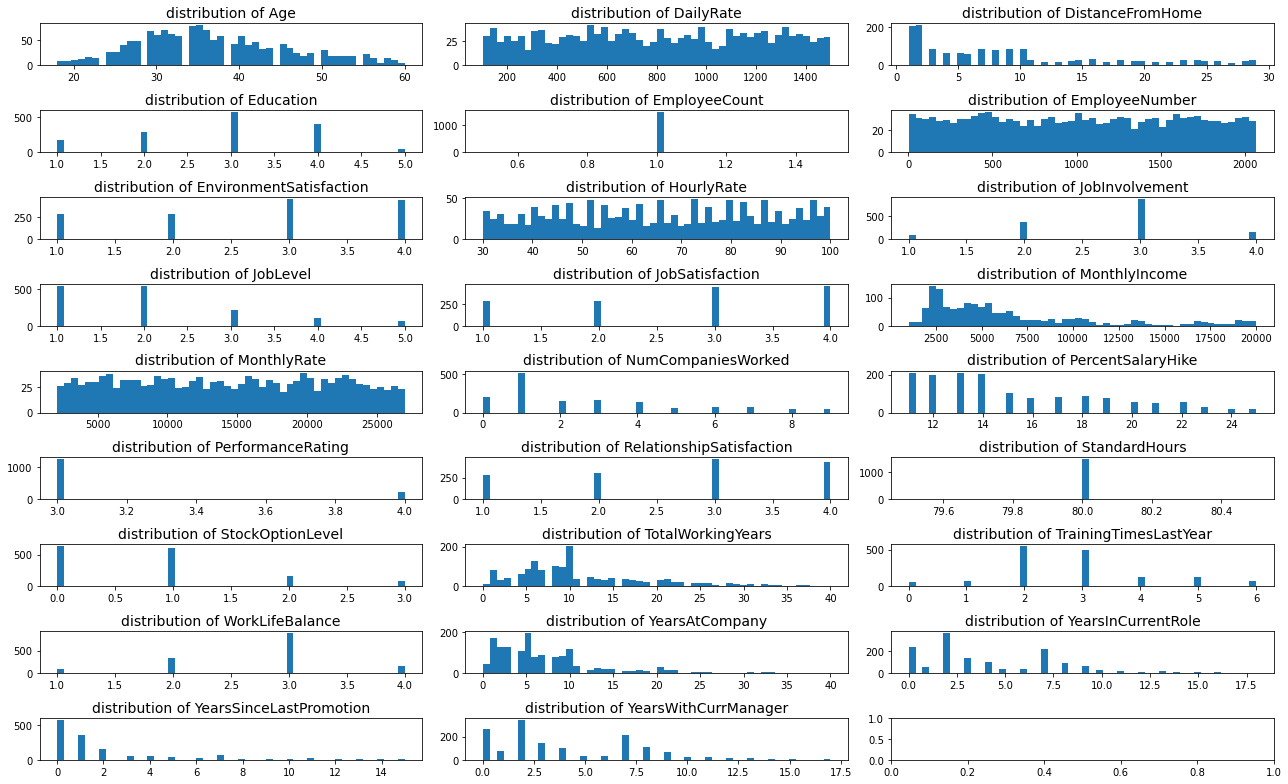

In [7]:
plotVarsDist(srcdf,vartype='conti',figsize=(18,11))

#### 發現異常沒有變異的變數，再次檢查後刪掉

In [8]:
checkvars = ['Over18','EmployeeCount','StandardHours']
for checkvar in checkvars:
    display(srcdf[checkvar].unique())
cleanedsrcdf = {'0dropped':srcdf.drop(columns=checkvars)}
continueousVars.remove('EmployeeCount')
continueousVars.remove('StandardHours')
categoricalVars.remove('Over18')

array(['Y'], dtype=object)

array([1], dtype=int64)

array([80], dtype=int64)

#### 某些變項應該是次序變項，重新指定

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobRole,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Education1,Education2,Education3,Education4,JobInvolvement1,JobInvolvement2,JobInvolvement3,JobLevel1,JobLevel2,JobLevel3,JobLevel4,JobSatisfaction1,JobSatisfaction2,JobSatisfaction3,PerformanceRating1,RelationshipSatisfaction1,RelationshipSatisfaction2,RelationshipSatisfaction3,StockOptionLevel1,StockOptionLevel2,StockOptionLevel3,WorkLifeBalance1,WorkLifeBalance2,WorkLifeBalance3
0,41,Travel_Rarely,1102,Sales,1,Life Sciences,1,1,2,Female,94,Sales Executive,Single,5993,19479,8,Y,Yes,11,80,8,0,6,4,0,5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49,Travel_Frequently,279,Research & Development,8,Life Sciences,1,2,3,Male,61,Research Scientist,Married,5130,24907,1,Y,No,23,80,10,3,10,7,1,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,37,Travel_Rarely,1373,Research & Development,2,Other,1,4,4,Male,92,Laboratory Technician,Single,2090,2396,6,Y,Yes,15,80,7,3,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,33,Travel_Frequently,1392,Research & Development,3,Life Sciences,1,5,4,Female,56,Research Scientist,Married,2909,23159,1,Y,Yes,11,80,8,3,8,7,3,0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,27,Travel_Rarely,591,Research & Development,2,Medical,1,7,1,Male,40,Laboratory Technician,Married,3468,16632,9,Y,No,12,80,6,3,2,2,2,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Travel_Frequently,884,Research & Development,23,Medical,1,2061,3,Male,41,Laboratory Technician,Married,2571,12290,4,Y,No,17,80,17,3,5,2,0,3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1466,39,Travel_Rarely,613,Research & Development,6,Medical,1,2062,4,Male,42,Healthcare Representative,Married,9991,21457,4,Y,No,15,80,9,5,7,7,1,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1467,27,Travel_Rarely,155,Research & Development,4,Life Sciences,1,2064,2,Male,87,Manufacturing Director,Married,6142,5174,1,Y,Yes,20,80,6,0,6,2,0,3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1468,49,Travel_Frequently,1023,Sales,2,Medical,1,2065,4,Male,63,Sales Executive,Married,5390,13243,2,Y,No,14,80,17,3,9,6,0,8,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


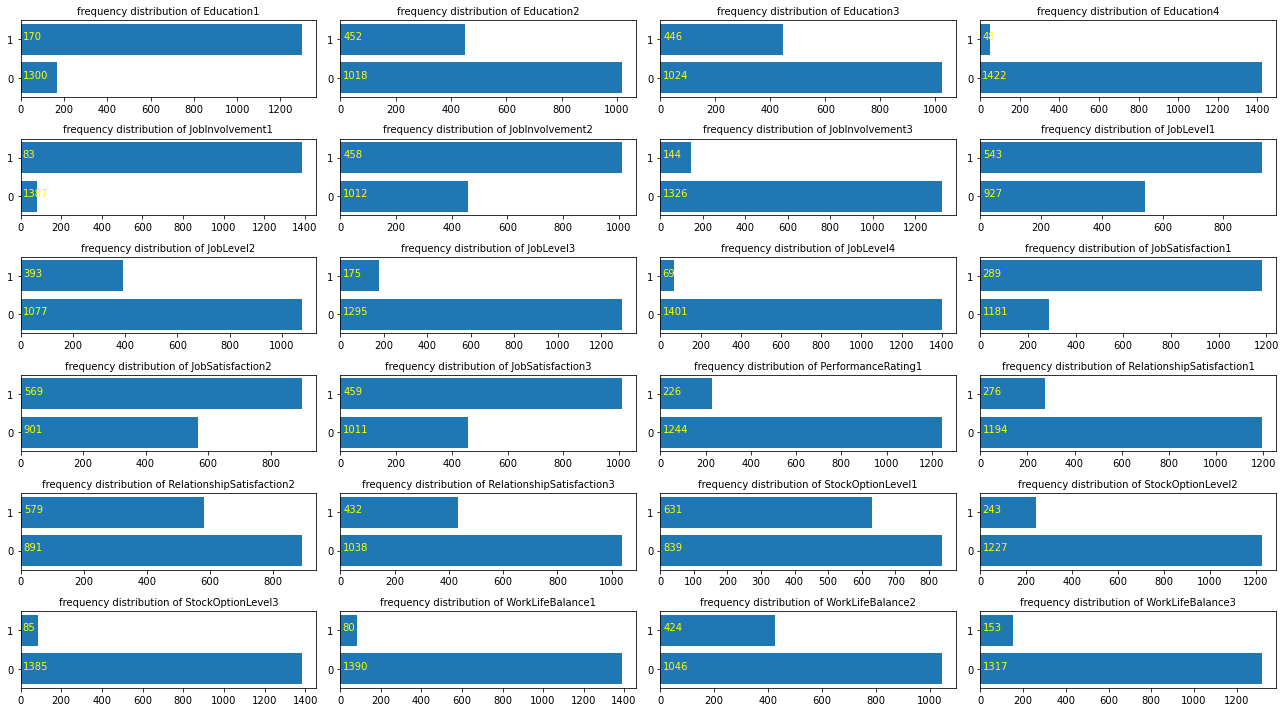

In [9]:
ordinalVars = ['Education','JobInvolvement','JobLevel','JobSatisfaction','PerformanceRating','RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']
ovDFs = []

#累積機率的encoding
for ov in ordinalVars:
    newOvcolnames = ['{}{}'.format(ov,i) for i in range(1,len(srcdf[ov].unique()))]
    ovV = condor.CondorOrdinalEncoder(nclasses=len(srcdf[ov].unique())).fit_transform(srcdf[ov]-srcdf[ov].min())
    ovDFs.append(pd.DataFrame(ovV, columns=newOvcolnames))
ovDFs = pd.concat(ovDFs, axis=1).reset_index(drop=True)
realContiVars = [col for col in continueousVars if col not in ordinalVars]
newOvcolnames = list(ovDFs.columns)
cleanedsrcdf['0dropped1ordinaled'] = pd.concat([srcdf.drop(columns=ordinalVars), ovDFs], axis=1)

display(cleanedsrcdf['0dropped1ordinaled'])
plotVarsDist(ovDFs.astype('category'),vartype='catg', nSubplotCols=4, figsize=(18,10), titlefontsize=10)

#### 檢查是否有離群值

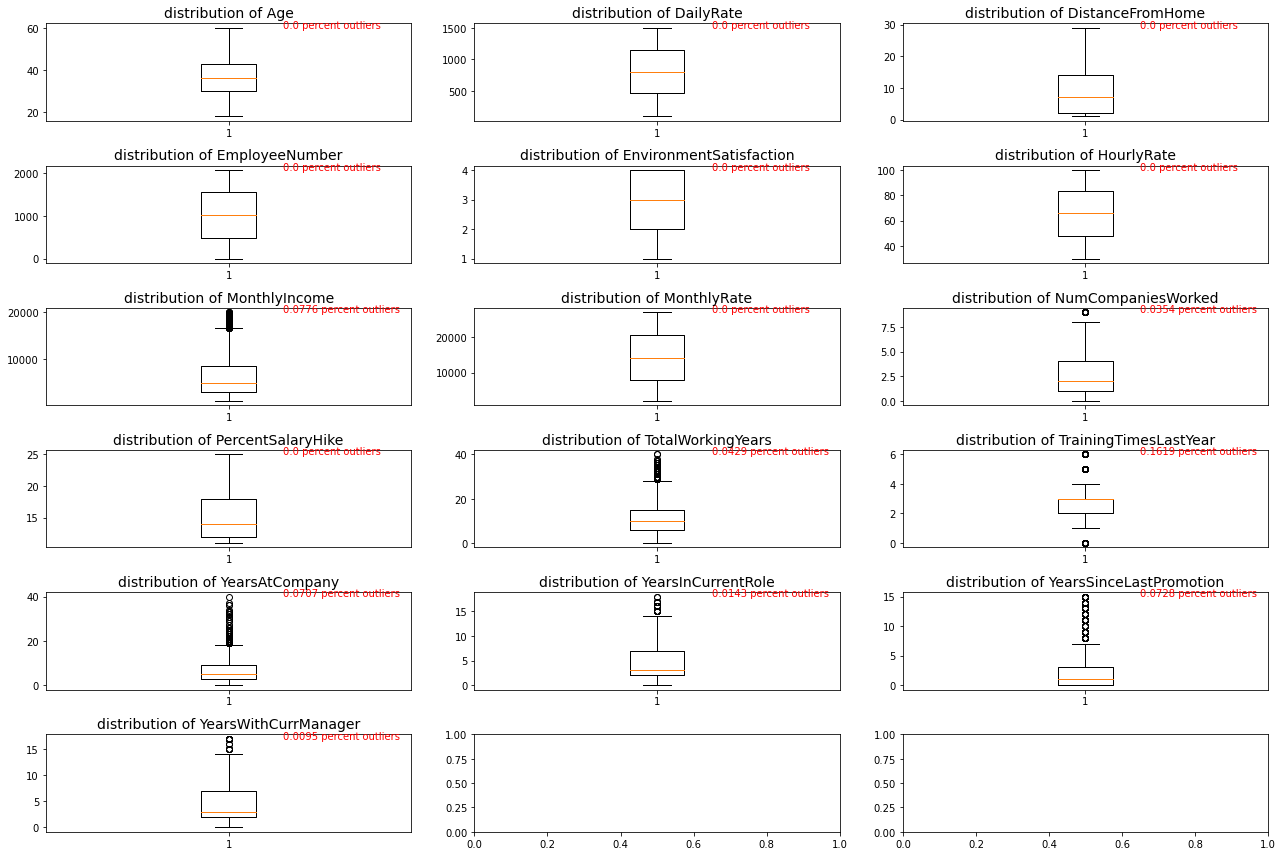

In [10]:
plotVarsDist(cleanedsrcdf['0dropped1ordinaled'],vartype='conti',chartType='boxplot',displayVars=realContiVars,figsize=(18,12))

#### 尺度標準化

In [11]:
#del cleanedsrcdf['0dropped2rbscaled']
#del cleanedsrcdf['0dropped1ordinaled2rbscaled']
#cleanedsrcdf.keys()

In [12]:
scalerModel = {}
for previousTestd in copy.deepcopy(list(cleanedsrcdf.keys())): #to avoid dict change error
    targetContiVars = continueousVars+ordinalVars if re.search('ordinal',previousTestd)==None else realContiVars
    scalerModel[previousTestd] = sklearn.preprocessing.RobustScaler().fit(cleanedsrcdf[previousTestd].loc[:,targetContiVars].to_numpy())
    #tmpOtherVars = (newOvcolnames if re.search('ordinal',previousTestd)!=None else ordinalVars)+categoricalVars
    tmpOtherVars = newOvcolnames if re.search('ordinal',previousTestd)!=None else categoricalVars

    dfdata = scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd].loc[:,targetContiVars].to_numpy())
    if dfdata.shape[1]!=len(targetContiVars):
        raise('not equal error')
    cleanedsrcdf[previousTestd+'2rbscaled'] = pd.DataFrame(
            data=dfdata,
            columns=targetContiVars
        ).reset_index(drop=True)
    #cleanedsrcdf[previousTestd+'2rbscaled'] = cleanedsrcdf[previousTestd+'2rbscaled'].rename(columns={i:x for i,x in enumerate(targetContiVars)})
    for col in tmpOtherVars:
        cleanedsrcdf[previousTestd+'2rbscaled'][col] = cleanedsrcdf[previousTestd][col].reset_index(drop=True)
    for col in cleanedsrcdf[previousTestd+'2rbscaled'].columns: #sometime a column would becomes a dataframe
        if isinstance(cleanedsrcdf[previousTestd+'2rbscaled'][col],pd.core.frame.DataFrame):
            print('type error at {} col {}'.format(previousTestd+'2rbscaled',col))
            tempseries = cleanedsrcdf[previousTestd+'2rbscaled'][col].reset_index(drop=True).iloc[:,0]
            cleanedsrcdf[previousTestd+'2rbscaled'] = cleanedsrcdf[previousTestd+'2rbscaled'].drop(columns=[col])
            cleanedsrcdf[previousTestd+'2rbscaled'][col] = tempseries
            #display(cleanedsrcdf[previousTestd+'2rbscaled'][col])

type error at 0dropped2rbscaled col Education
type error at 0dropped2rbscaled col JobInvolvement
type error at 0dropped2rbscaled col JobLevel
type error at 0dropped2rbscaled col JobSatisfaction
type error at 0dropped2rbscaled col PerformanceRating
type error at 0dropped2rbscaled col RelationshipSatisfaction
type error at 0dropped2rbscaled col StockOptionLevel
type error at 0dropped2rbscaled col WorkLifeBalance


In [13]:
#cleanedsrcdf['0dropped2rbscaled']['Education']
#scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd].loc[:,targetContiVars])
#scalerModel[previousTestd].transform(cleanedsrcdf[previousTestd].loc[:,targetContiVars].to_numpy()).shape
#len(targetContiVars)

In [13]:
for previousTestd,tempdf in cleanedsrcdf.items():
    for col in tempdf.columns:
        try:
            t = tempdf[col].unique()
        except Exception as e:
            print('error at previousTestd {} col {} for {}'.format(previousTestd, col, e))

### 最開始直接什麼預處理都不作以最簡單的Random Forest嘗試作為baseline（演算法特性較不依賴特徵工程）

testsrc is 0dropped and drop_first is True
value of targetmetric accuracy is 0.8619047619047618 in avg
value of targetmetric f1 is 0.2699145077547981 in avg
value of targetmetric roc_auc is 0.8063380375087453 in avg
value of targetmetric balanced_accuracy is 0.5786980699723442 in avg
testsrc is 0dropped and drop_first is False
value of targetmetric accuracy is 0.864625850340136 in avg
value of targetmetric f1 is 0.33335887020116417 in avg
value of targetmetric roc_auc is 0.8064757623979247 in avg
value of targetmetric balanced_accuracy is 0.6007629042017444 in avg
testsrc is 0dropped1ordinaled and drop_first is True
value of targetmetric accuracy is 0.8578231292517007 in avg
value of targetmetric f1 is 0.24509163130811587 in avg
value of targetmetric roc_auc is 0.809723589316391 in avg
value of targetmetric balanced_accuracy is 0.569372777778945 in avg
testsrc is 0dropped1ordinaled and drop_first is False
value of targetmetric accuracy is 0.8585034013605443 in avg
value of targetmetric

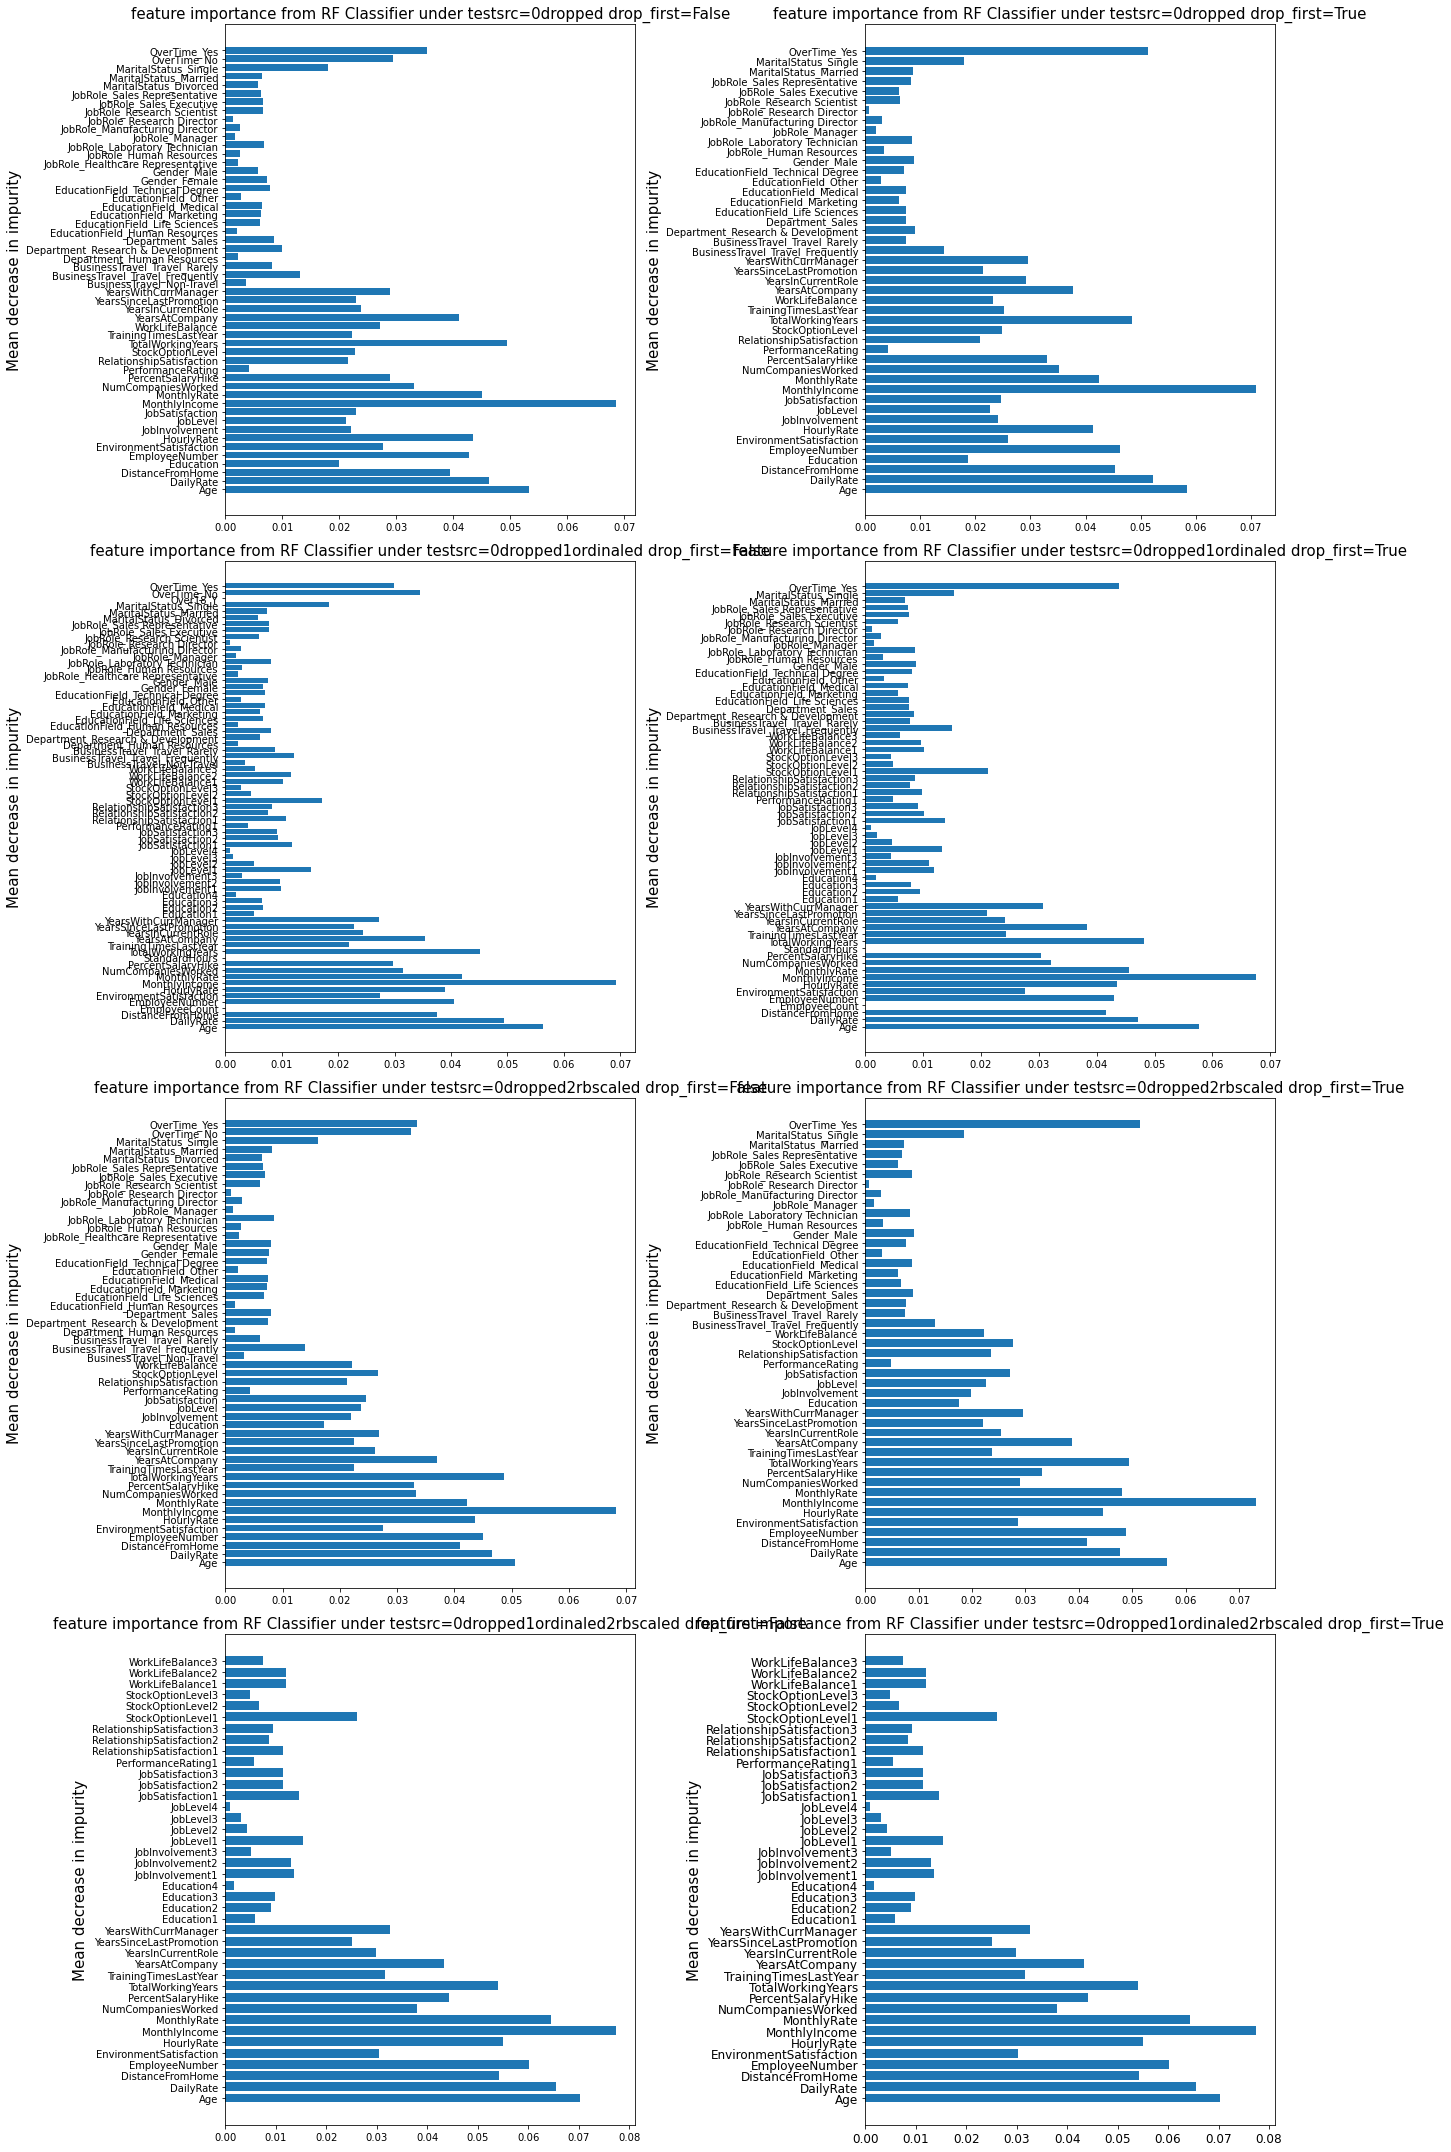

,rbscaled,drop_first,score
ordinaled,,,
False,0.5,0.5,0.633269
True,0.5,0.5,0.598387


,ordinaled,drop_first,score
rbscaled,,,
False,0.5,0.5,0.631312
True,0.5,0.5,0.600344


,ordinaled,rbscaled,score
drop_first,,,
False,0.5,0.5,0.620747
True,0.5,0.5,0.610909


,ordinaled,rbscaled,drop_first,score
metric,,,,
accuracy,0.5,0.5,0.5,0.856888
balanced_accuracy,0.5,0.5,0.5,0.571385
f1,0.5,0.5,0.5,0.249289
roc_auc,0.5,0.5,0.5,0.785750


In [14]:
testnSubplotCols = 2
fig, ax = plt.subplots(len(cleanedsrcdf), testnSubplotCols, figsize=(18, 30))
figrowi=-1
datai=0
tempEvaluationDicts = []
for testsrc in cleanedsrcdf:
    iftestsrcordinaled = re.search('ordinaled',testsrc)!=None
    iftestsrcrbscaled = re.search('rbscaled',testsrc)!=None
    dummiedSrcdfX = cleanedsrcdf[testsrc]
    figrowi += 1
    for drop_first in [True,False]:
        datai += 1
        print('testsrc is {} and drop_first is {}'.format(testsrc,drop_first))
        dummiedSrcdfXAfterDrop = pd.get_dummies(dummiedSrcdfX, drop_first=drop_first)

        clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
        clf.fit(dummiedSrcdfXAfterDrop,y=lbzedSrcdfY)
        std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
        ax[figrowi][datai%testnSubplotCols].barh(dummiedSrcdfXAfterDrop.columns, clf.feature_importances_, xerr=std, align='center')

        ax[figrowi][datai%testnSubplotCols].set_title("feature importance from RF Classifier under testsrc={} drop_first={}".format(testsrc, drop_first), fontsize=15)
        ax[figrowi][datai%testnSubplotCols].set_ylabel("Mean decrease in impurity", fontsize=15)
        plt.xticks(fontsize=12, rotation=0)
        plt.yticks(fontsize=12, rotation=0)
        for targetmetric in ['accuracy','f1','roc_auc','balanced_accuracy']:
            cvscores = sklearn.model_selection.cross_val_score(clf, dummiedSrcdfXAfterDrop, lbzedSrcdfY, cv=5, scoring=targetmetric)
            print('value of targetmetric {} is {} in avg'.format(
                targetmetric,
                np.mean(cvscores)
                ))
            tempEvaluationDicts.append({'ordinaled':iftestsrcordinaled, 'rbscaled':iftestsrcrbscaled, 'metric':targetmetric, 'drop_first':drop_first, 'score':np.mean(cvscores)})
plt.tight_layout()
plt.show()
pretestMetrics = pd.DataFrame.from_records(tempEvaluationDicts)
for testAttr in ['ordinaled','rbscaled','drop_first']:
    display(pretestMetrics.groupby(testAttr).agg('mean'))
display(pretestMetrics.groupby('metric').agg('mean'))

#### 變數之間相關圖

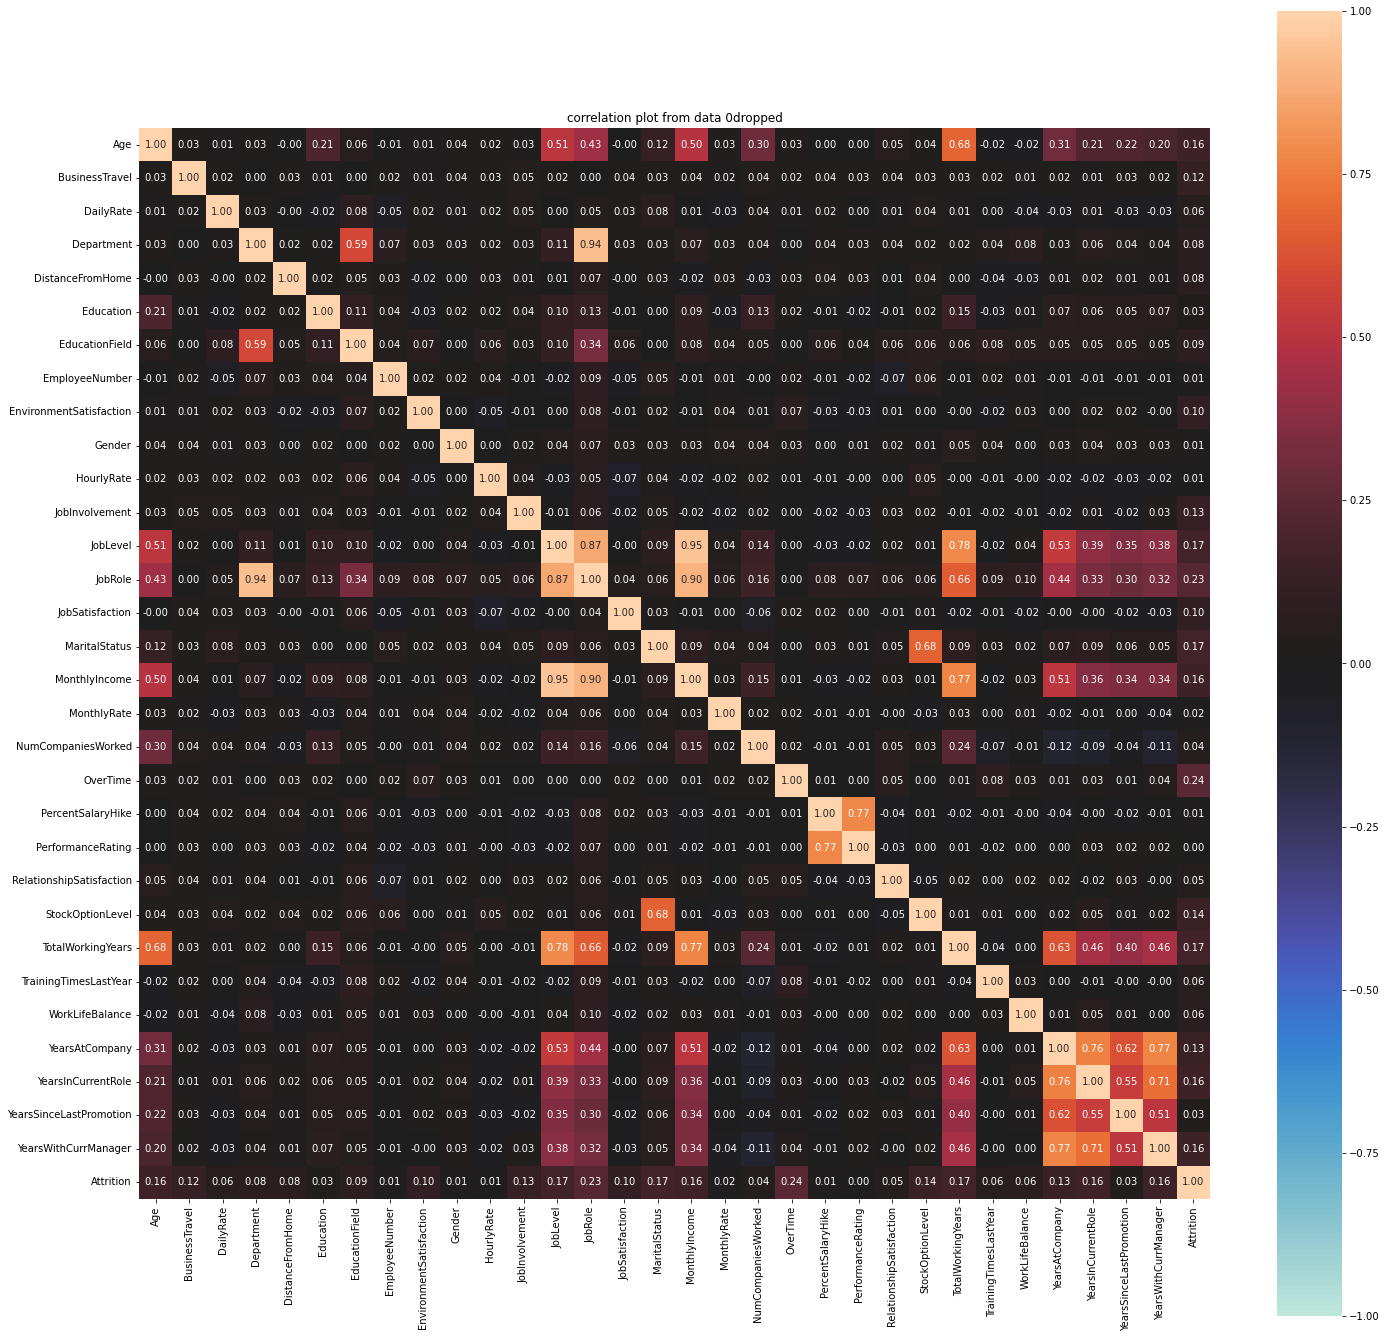

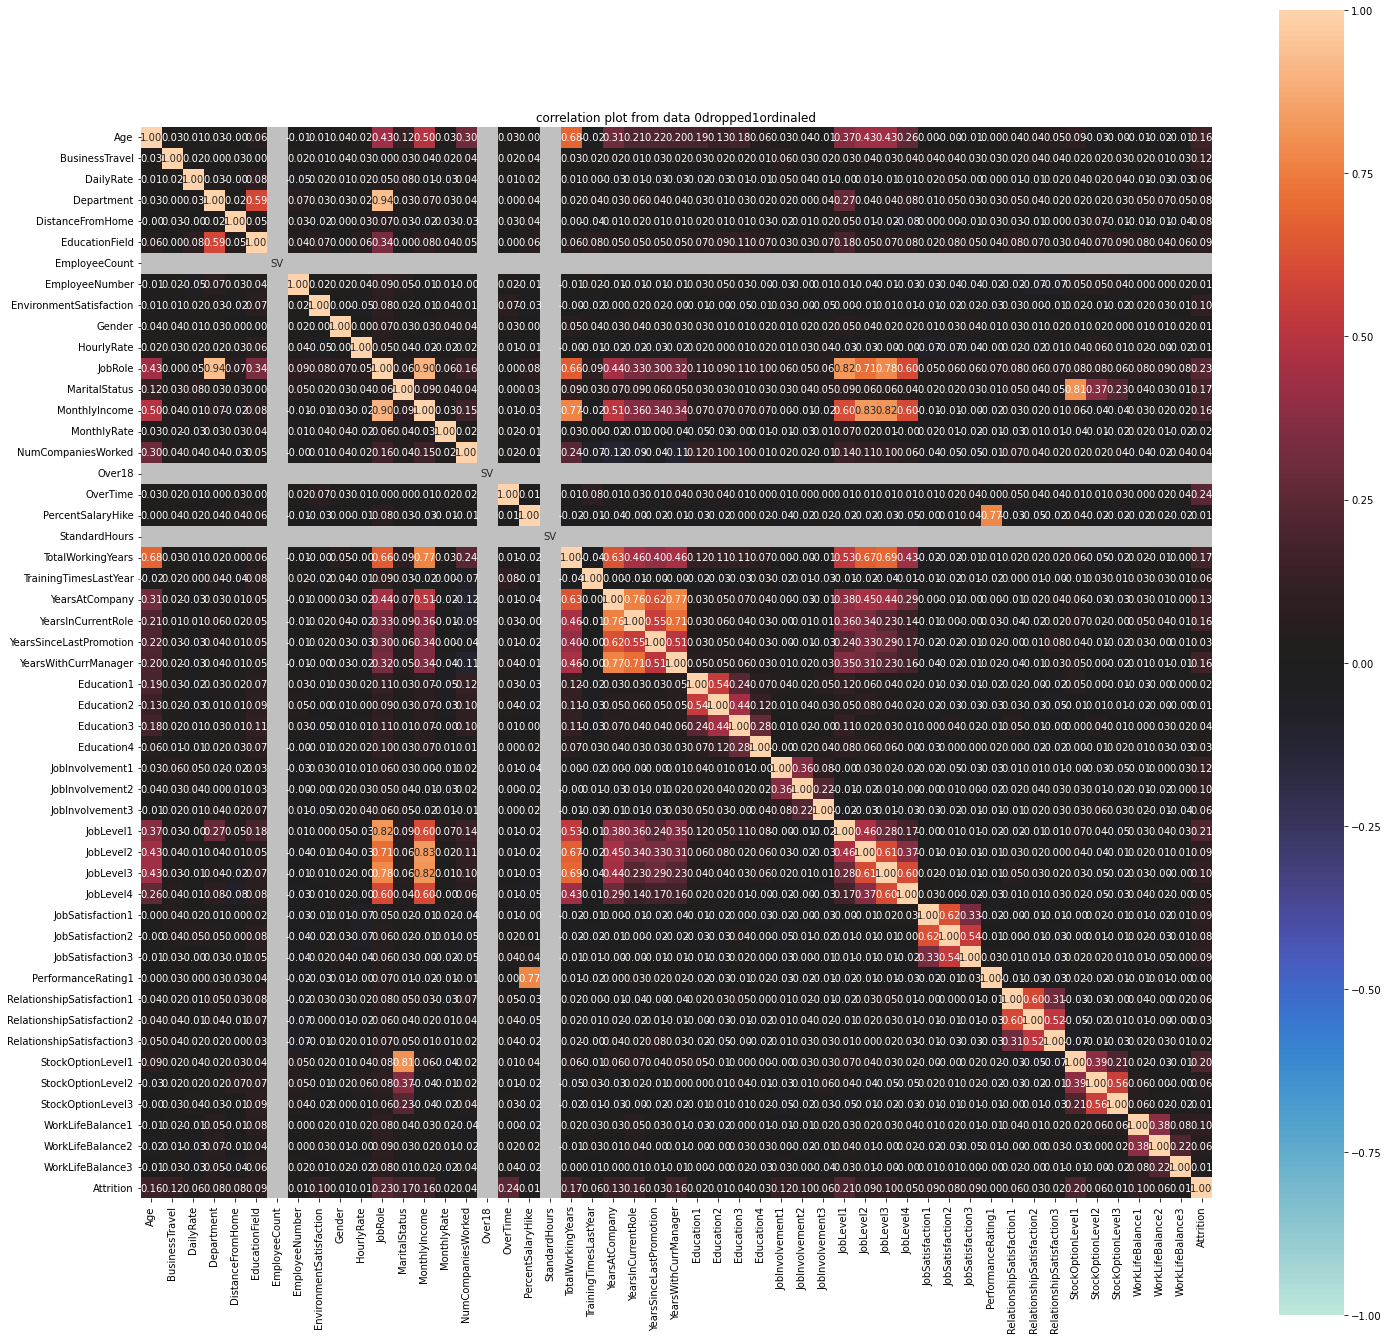

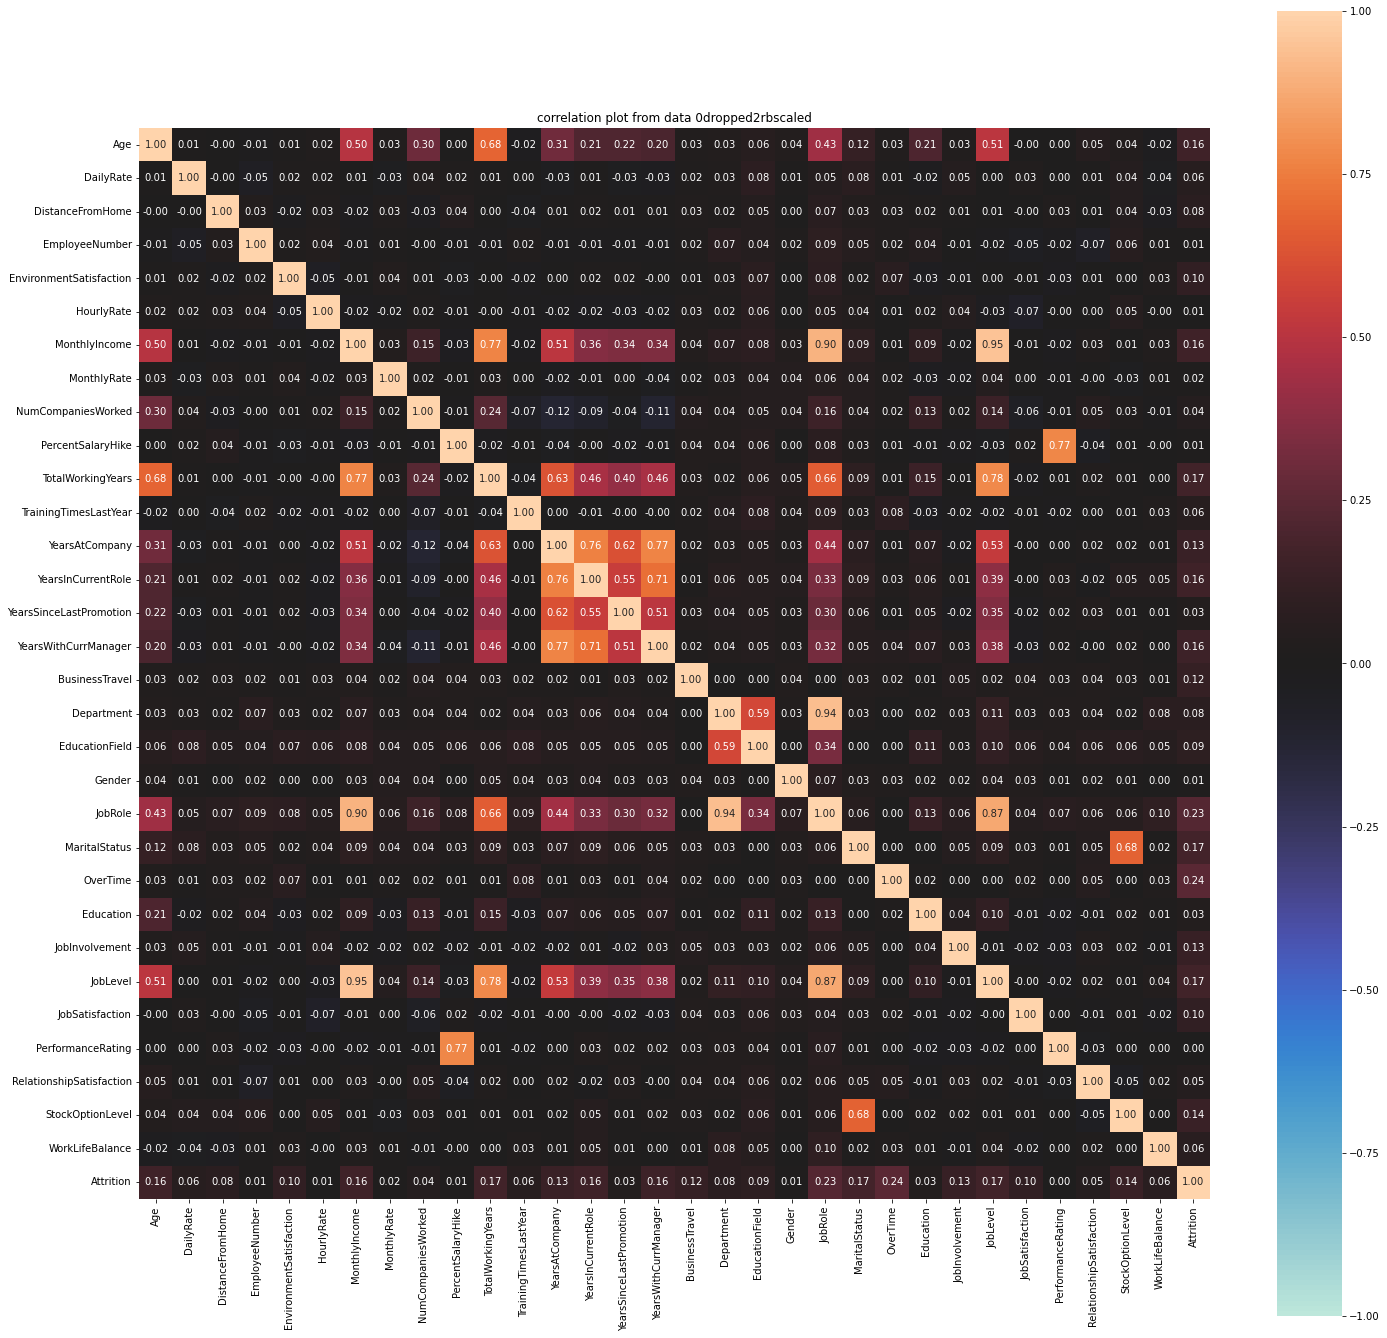

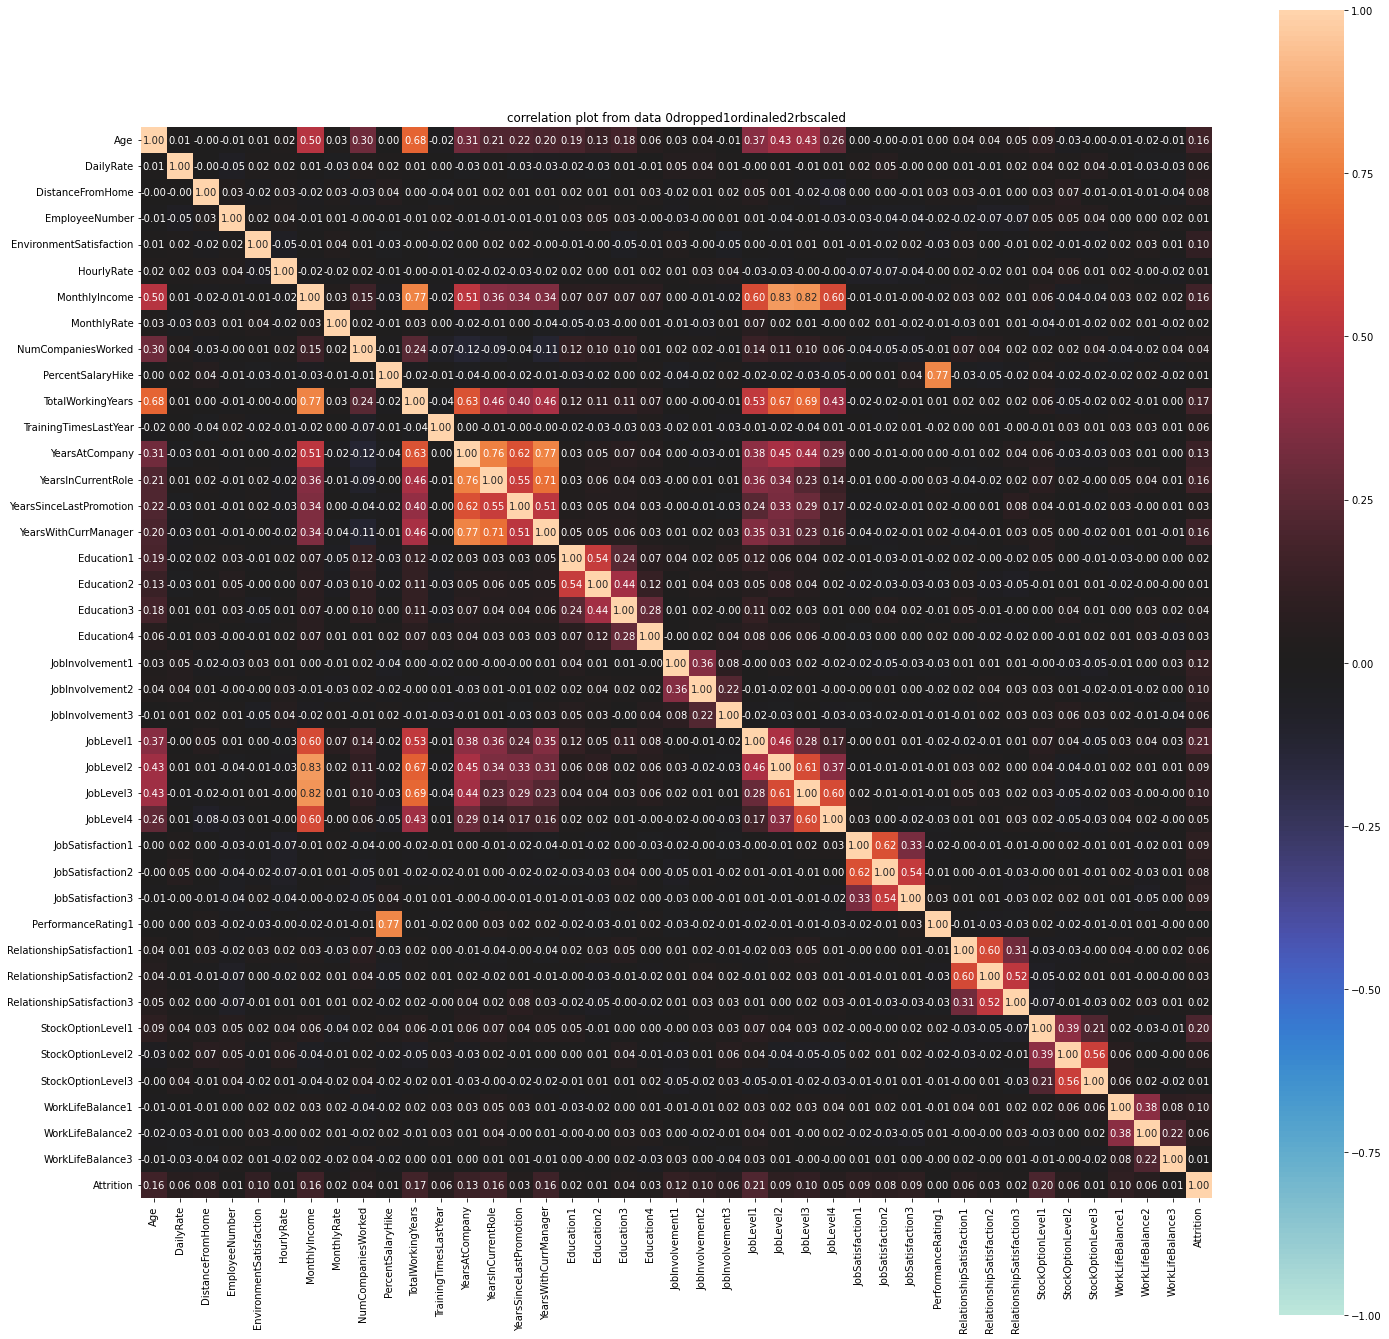

In [15]:
for previousTestd in cleanedsrcdf.keys():
    dython.nominal.associations(
        pd.concat([cleanedsrcdf[previousTestd], srcdfY], axis=1).reset_index(drop=True),
        #cleanedsrcdf[previousTestd],
        figsize=(24,24), title=f'correlation plot from data {previousTestd}')

#pd.plotting.scatter_matrix(cleanedsrcdf['0dropped1ordinaled2rbscaled'], figsize=(40,40), marker = 'o', hist_kwds = {'bins': 50}, s = 60, alpha = 0.9)

可以看到1.在公司與職位年資 2.職務等級與工資率 是明顯彼此高度相關有重疊的指標，意味著要構面縮減時至少可以分門別類將這些指標各自縮成同一個構面（例如前者縮成【在公司與職務資深度】，後者縮成【階級】）


### 構面縮減

#### 傳統PCA（供參考，不實際使用）

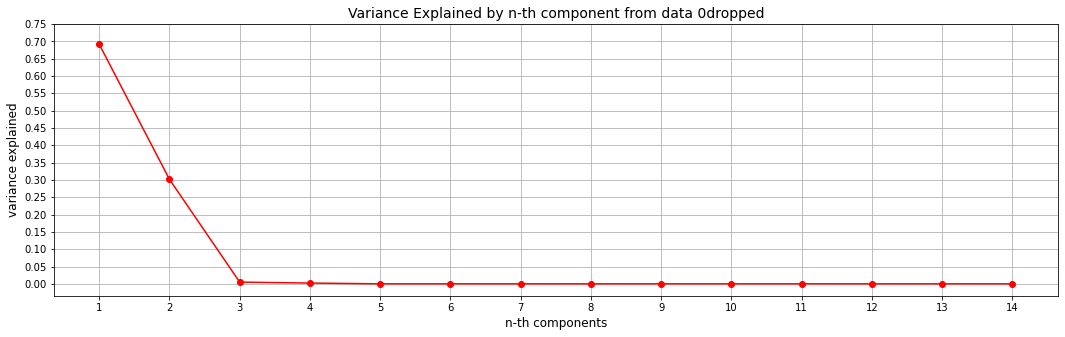

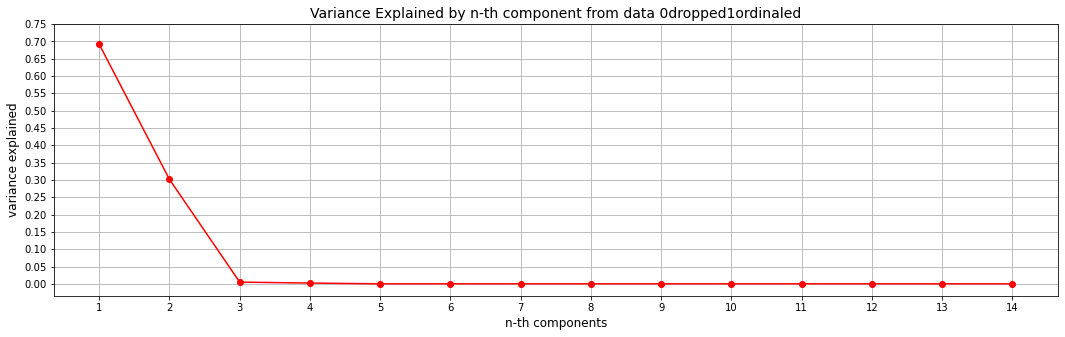

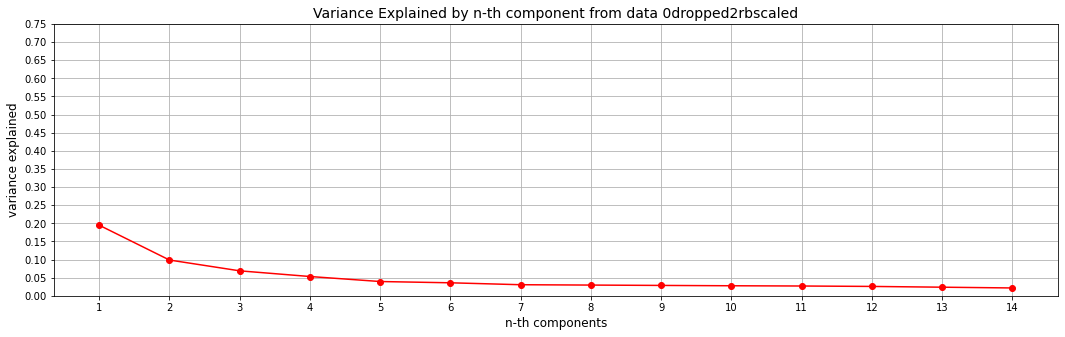

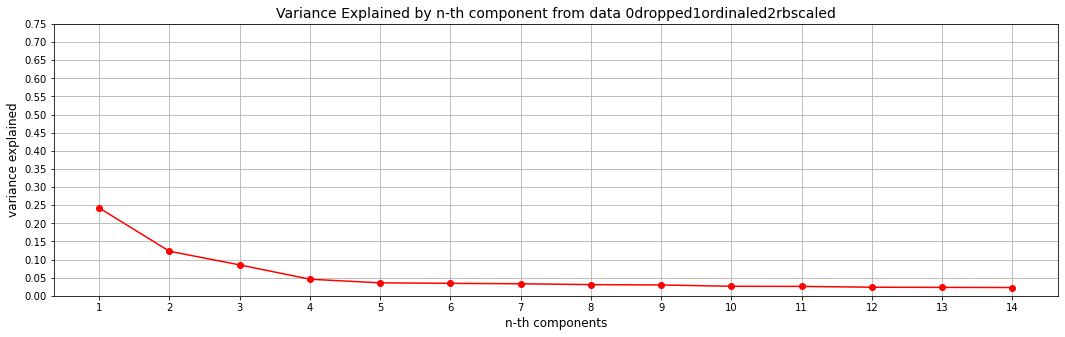

In [16]:
pcaTestRangeMax = 15
pcaTestRange = np.arange(1,pcaTestRangeMax,1)
pcaTransformers = {}

for previousTestd in cleanedsrcdf:
    pcaTransformers[previousTestd] = {n:sklearn.decomposition.PCA(n, random_state=0).fit(pd.get_dummies(cleanedsrcdf[previousTestd])) for n in pcaTestRange}
    plt.figure(figsize=(18, 5))
    plt.plot(pcaTestRange,pcaTransformers[previousTestd][pcaTestRange[-1]].explained_variance_ratio_, color='red', marker='o')
    plt.xticks(pcaTestRange)
    plt.yticks(np.arange(0,0.8,0.05))
    plt.grid(True)
    plt.title(f'Variance Explained by n-th component from data {previousTestd}', fontsize=14)
    plt.xlabel('n-th components', fontsize=12)
    plt.ylabel('variance explained', fontsize=12)

4個component可解釋變異約僅 0.1875+0.1+0.069+0.05=0.4065

#### 透過 Variational AutoEncoder 構面縮減

In [16]:
from apps.attritionml.mlmodeldefinition import getVaeEncoder,getVaeModel
vae_built_on_data_type = '0dropped2rbscaled'

In [18]:
fitdata = pd.get_dummies(cleanedsrcdf[vae_built_on_data_type]).astype('float64').to_numpy()
vaeFittingRes = {}
vaeModels = {}
dimsToLoss = {}
for ldim in [4,8,12,24,32,64]:
    vaeModels[ldim] = getVaeModel(ldim, fitdata.shape[1])
    earlystopcallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=60, verbose=1, mode='min', restore_best_weights=True)
    reducelrcallback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.6,patience=15,verbose=1)
    vaeFittingRes[ldim] = vaeModels[ldim].fit(x=fitdata, y=fitdata, epochs=3000, batch_size=64, callbacks=[earlystopcallback,reducelrcallback])
    dimsToLoss[ldim] = min(vaeFittingRes[ldim].history['loss'])
    print('min loss at dim {} is {}'.format(ldim, dimsToLoss[ldim]))
    vaeModels[ldim].save('vae-dim{}-loss{}.h5'.format(ldim,dimsToLoss[ldim]))

Epoch 1/3000
23/23 [==============================] - 3s 35ms/step - loss: 866.9848 - lr: 5.0000e-04
Epoch 2/3000
23/23 [==============================] - 1s 33ms/step - loss: 707.0100 - lr: 5.0000e-04
Epoch 3/3000
23/23 [==============================] - 1s 33ms/step - loss: 593.1069 - lr: 5.0000e-04
Epoch 4/3000
23/23 [==============================] - 1s 33ms/step - loss: 520.8800 - lr: 5.0000e-04
Epoch 5/3000
23/23 [==============================] - 1s 33ms/step - loss: 466.8824 - lr: 5.0000e-04
Epoch 6/3000
23/23 [==============================] - 1s 34ms/step - loss: 430.8793 - lr: 5.0000e-04
Epoch 7/3000
23/23 [==============================] - 1s 34ms/step - loss: 401.4403 - lr: 5.0000e-04
Epoch 8/3000
23/23 [==============================] - 1s 33ms/step - loss: 373.4408 - lr: 5.0000e-04
Epoch 9/3000
23/23 [==============================] - 1s 33ms/step - loss: 350.9603 - lr: 5.0000e-04
Epoch 10/3000
23/23 [==============================] - 1s 34ms/step - loss: 336.0923 - lr: 

實驗紀錄
* best by relu batchsize 64 and 4 hidden size is 174.5532
* best by leakyrelu batchsize 64 and 4 hidden size is 167.0726
* best by selu batchsize 64 and 4 hidden size is 167.0726
* best by Prelu batchsize 64 and 4 hidden size is 164.8862
* best by CNN batchsize and 4 hidden size 64 is 164.6893
* best by Prelu batchsize 64 loss and 6 hidden size: 154.1259
* best by Prelu batchsize 64 loss and 10 hidden size: 129.8
* best by Prelu batchsize 64 loss and 16 hidden size: 129.8
* {4: 161.62901306152344, 8: 138.72447204589844, 12: 118.9158706665039, 16: 103.81063842773438, 32: 99.14110565185547}
* {4: 192.1639862060547, 8: 144.4535675048828, 12: 117.8581771850586, 24: 107.50943756103516, 32: 92.59283447265625, 64: 101.70317077636719}

In [19]:
def plotTrainingHistory(trainhistory):
    plt.plot(trainhistory.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
display(dimsToLoss)


{4: 192.1639862060547,
 8: 144.4535675048828,
 12: 117.8581771850586,
 24: 107.50943756103516,
 32: 92.59283447265625,
 64: 101.70317077636719}

In [22]:
encoder_reconstructed = getVaeModel(32,pd.get_dummies(cleanedsrcdf[vae_built_on_data_type]).astype('float64').shape[1])
encoder_reconstructed.load_weights('vae-dim32-loss92.59283447265625.h5')
encoder_reconstructed = tf.keras.models.Sequential(encoder_reconstructed.layers[:2])
encoder_reconstructed.summary()
#custom_objects={'Sampling':Sampling,'vae_loss':vae_loss}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoderModel (Functional)   (None, 32)                3552      
                                                                 
Total params: 3,552
Trainable params: 3,456
Non-trainable params: 96
_________________________________________________________________


In [23]:
kpcaTransformer = sklearn.decomposition.KernelPCA(n_components=12,kernel='rbf').fit_transform(pd.get_dummies(cleanedsrcdf['0dropped1ordinaled2rbscaled']).astype('float64'))
cleanedsrcdf['0dropped1ordinaled2rbscaled3pca'] = kpcaTransformer
print(cleanedsrcdf['0dropped1ordinaled2rbscaled3pca'].shape)

(1470, 12)


In [109]:
#dimReductionByVAE = 
#t = pd.get_dummies(cleanedsrcdf[srcdftype]).astype('float64')
#sys.exit()
for srcdftype in [vae_built_on_data_type]:
    newsrcdftype = srcdftype+'4vae'
    cleanedsrcdf[newsrcdftype] = encoder_reconstructed.predict(pd.get_dummies(cleanedsrcdf[srcdftype]).astype('float64'))
    display('orig shape {} vae to {}'.format(cleanedsrcdf[srcdftype].shape,cleanedsrcdf[newsrcdftype].shape))

46/46 [==============================] - 0s 3ms/step


'orig shape (1470, 47) vae to (1470, 16)'

### Fitting

#### 因為標籤分布不均所以計算並使用class weight

In [14]:
attrition_classWeights = sklearn.utils.class_weight.compute_class_weight('balanced',classes=np.unique(lbzedSrcdfY),y=lbzedSrcdfY)
#attrition_classWeights
attrition_classWeights_dict = dict(zip(np.unique(lbzedSrcdfY),attrition_classWeights))
attrition_sampleweights = sklearn.utils.class_weight.compute_sample_weight(attrition_classWeights_dict, y=lbzedSrcdfY)
display(attrition_classWeights, attrition_sampleweights)

array([0.59610706, 3.10126582])

array([3.10126582, 0.59610706, 3.10126582, ..., 0.59610706, 0.59610706,
       0.59610706])

## Pipeline 超參數網格搜尋
* 參考：https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline
* 使用 average_precision_score 針對資料不平衡情形評估模型成效

In [17]:
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = sklearn.linear_model.SGDClassifier(),
        class_weight = None,
        sample_weight = None,
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator
        self.sample_weight = sample_weight
        self.class_weight = class_weight
    def newXandSampleWeight(self, X):
        if self.sample_weight==True:
            sample_weight = X['sampleweight']
        else:
            sample_weight = None
        X = X.drop(columns='sampleweight')
        return X, sample_weight

    def fit(self, X, y=None, **kwargs): #
        X,sample_weight = self.newXandSampleWeight(X)
        self.estimator.fit(X, y, sample_weight=sample_weight)
        return self
    def predict(self, X, y=None):
        X = X.drop(columns='sampleweight')
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def score(self, X, y, sample_weight=None):
        X,sample_weight = self.newXandSampleWeight(X)
        y_score = self.estimator.predict_proba(X)[:, 1]
        average_precision = sklearn.metrics.average_precision_score(y, y_score, sample_weight=sample_weight)
        return average_precision
        #return self.estimator.score(X, y)

pipeline = sklearn.pipeline.Pipeline([
    ('clf', ClfSwitcher()),
])
parameters = [
    {
        'clf__estimator': [sklearn.ensemble.RandomForestClassifier()],
        'clf__sample_weight': [False, True],
        'clf__estimator__max_depth': [None,5,10,20],
        'clf__estimator__min_samples_split': [2,10],
        'clf__estimator__min_samples_leaf': [1,2,10],
    },
    {
        'clf__estimator': [sklearn.linear_model.LogisticRegression()],
        'clf__estimator__penalty': ['l1','l2','elasticnet'],
        'clf__sample_weight': [False, True],
    },
    {
        'clf__estimator': [sklearn.linear_model.SGDClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__sample_weight': [False, True],
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    },
    {
        'clf__estimator': [sklearn.svm.SVC()],
        'clf__estimator__C': [0.5,1.0,3.0,10.0],
        'clf__estimator__kernel': ['poly', 'rbf'],
        'clf__sample_weight': [False, True],
    },
]
gridcvdata = pd.get_dummies(cleanedsrcdf[vae_built_on_data_type])
gridcvdata['sampleweight'] = attrition_sampleweights
display(gridcvdata.shape)
gscv = sklearn.model_selection.GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3)
gscv.fit(gridcvdata, lbzedSrcdfY)
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_score', ascending=False)

(1470, 53)

Fitting 5 folds for each of 106 candidates, totalling 530 fits


f:\Software\Miniconda3\envs\py310ds\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 530.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Software\Miniconda3\envs\py310ds\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Software\Miniconda3\envs\py310ds\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "F:\Temp\dowba\ipykernel_12472\3548175045.py", line 27, in fit
  File "f:\Software\Miniconda3\envs\py310ds\lib\site-pa

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__max_depth,param_clf__estimator__min_samples_leaf,param_clf__estimator__min_samples_split,param_clf__sample_weight,param_clf__estimator__penalty,param_clf__estimator__loss,param_clf__estimator__max_iter,param_clf__estimator__tol,param_clf__estimator__C,param_clf__estimator__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.170204,0.089577,0.004001,0.000896,LogisticRegression(),NaN,NaN,NaN,True,l2,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': LogisticRegression(), 'clf_...",0.886323,0.844244,0.847427,0.831258,0.850904,0.852031,0.018388,1
41,1.180101,0.030868,0.095618,0.040625,RandomForestClassifier(),20,2,2,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.816257,0.828775,0.855258,0.772807,0.835181,0.821656,0.027489,2
11,0.749512,0.008316,0.048423,0.034296,RandomForestClassifier(),None,10,10,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.834721,0.804051,0.850475,0.780627,0.835318,0.821039,0.025216,3
7,0.764036,0.044521,0.067387,0.023168,RandomForestClassifier(),None,2,10,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.826928,0.818495,0.850705,0.765968,0.842213,0.820862,0.029672,4
45,0.929612,0.056236,0.025200,0.004622,RandomForestClassifier(),20,10,2,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.807378,0.827063,0.852408,0.757745,0.846107,0.818140,0.034057,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.251803,0.067595,0.002192,0.000982,SVC(),NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,3.0,rbf,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,87
102,0.304799,0.062426,0.001199,0.000400,SVC(),NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,10.0,poly,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
103,0.262399,0.018928,0.001199,0.000399,SVC(),NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,10.0,poly,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,75
104,0.325408,0.042815,0.001996,0.000889,SVC(),NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,10.0,rbf,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,93


### 測試VAE降維之後預測成效，結果顯示沒有提升（可能原因是VAE導致資訊損失）

In [84]:
gridcvdata = encoder_reconstructed.predict(pd.get_dummies(cleanedsrcdf[vae_built_on_data_type]).astype('float64'))
gridcvdata = pd.DataFrame(gridcvdata)
gridcvdata['sampleweight'] = attrition_sampleweights
gscv = sklearn.model_selection.GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3)
gscv.fit(gridcvdata, lbzedSrcdfY)
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_score', ascending=False)

46/46 [==============================] - 0s 3ms/step
Fitting 5 folds for each of 106 candidates, totalling 530 fits


f:\Software\Miniconda3\envs\py310ds\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 530.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Software\Miniconda3\envs\py310ds\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Software\Miniconda3\envs\py310ds\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "F:\Temp\dowba\ipykernel_14592\2608681392.py", line 27, in fit
  File "f:\Software\Miniconda3\envs\py310ds\lib\site-pa

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__max_depth,param_clf__estimator__min_samples_leaf,param_clf__estimator__min_samples_split,param_clf__sample_weight,param_clf__estimator__penalty,param_clf__estimator__loss,param_clf__estimator__max_iter,param_clf__estimator__tol,param_clf__estimator__C,param_clf__estimator__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.067992,0.048736,0.004601,0.003262,LogisticRegression(),NaN,NaN,NaN,True,l2,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': LogisticRegression(), 'clf_...",0.842963,0.785576,0.795825,0.782006,0.803696,0.802013,0.021856,1
47,1.557996,0.071226,0.052003,0.042386,RandomForestClassifier(),20,10,10,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.814690,0.753227,0.793878,0.752560,0.743773,0.771626,0.027668,2
9,1.170399,0.030111,0.048199,0.038025,RandomForestClassifier(),None,10,2,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.794811,0.743768,0.790827,0.765241,0.748078,0.768545,0.021119,3
45,1.253597,0.026868,0.087202,0.036815,RandomForestClassifier(),20,10,2,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.805453,0.752763,0.785748,0.751361,0.746156,0.768296,0.023253,4
23,1.031998,0.046817,0.061600,0.035607,RandomForestClassifier(),5,10,10,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__estimator': RandomForestClassifier(), '...",0.803655,0.758400,0.787903,0.746919,0.739919,0.767359,0.024456,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.245600,0.031294,0.001001,0.000002,SVC(),NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,3.0,rbf,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
102,0.220396,0.054968,0.001202,0.000401,SVC(),NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,10.0,poly,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,77
103,0.243999,0.045288,0.001003,0.000002,SVC(),NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,10.0,poly,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
104,0.212195,0.036984,0.001202,0.000399,SVC(),NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,10.0,rbf,"{'clf__estimator': SVC(), 'clf__estimator__C':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,93


### 依照上面找到表現最佳的超參數建模並存檔

In [18]:
#param_clf__estimator	param_clf__sample_weight	param_clf__estimator__penalty
#LogisticRegression()	True	                    l2

attritionClassifier = sklearn.linear_model.LogisticRegression(penalty='l2')
attritionClassifier.fit(gridcvdata.drop(columns='sampleweight'), lbzedSrcdfY, sample_weight=attrition_sampleweights) 
with open('attritionClassifier.pkl', 'wb') as f:
    pickle.dump(attritionClassifier, f)